In [24]:
STACK_LEN          = 400          # desired discriminator FC length
CHUNK_LIST         = [50, 100, 200]
G_LIST             = [600, 800, 1000, 1200, 1400]
SUBJ_MAIN          = 18           # main subject
AUGMENT_SUBJECTS   = list(range(1, 10)) + list(range(20, 50))  # e.g. [4, 7, 22] to mix others; [] ⇒ single-subject
FAKE_PER_STYLE     = 20
MAX_REAL           = 500          # cap real FCs
REAL_MULTIPLIER    = 2            
BATCH_DISC         = 32           # discriminator mini-batch
EPOCHS_DISC        = 20
SAVE_PATH   = f"weights/disc_sub{SUBJ_MAIN:03d}_len{STACK_LEN}_hinge.pt"

# GEN_WEIGHTS        = f"weights/gen_sub{SUBJ_MAIN:03d}_g1200_chunk100.pt"
# DISC_WEIGHTS_OUT   = f"weights/disc_sub{SUBJ_MAIN:03d}_len{STACK_LEN}.pt"

In [25]:
import os, itertools, random, numpy as np, torch, matplotlib.pyplot as plt, seaborn as sns
from pathlib import Path; sns.set_style("white")
from torch.utils.data import Dataset, DataLoader
from scipy.stats import pearsonr
from tqdm import trange
from whobpyt.data_loader import BOLDDataLoader, DEVICE
from simulators.rww_simulator import RWWSubjectSimulator
from whobpyt.models.fc_cnn_disc import FCCNNDisc
from whobpyt.utils.fc_tools       import bold_to_fc

In [26]:
# assert STACK_LEN % CHUNK == 0, "STACK_LEN must be an integer multiple of CHUNK"
# K_STACK = STACK_LEN // CHUNK

DATA_ROOT = "/vol/bitbucket/ank121/fyp/HCP Data"
fmri  = os.path.join(DATA_ROOT, "BOLD Timeseries HCP.mat")
scdir = os.path.join(DATA_ROOT, "distance_matrices")
dist  = os.path.join(DATA_ROOT, "schaefer100_dist.npy")
loader = BOLDDataLoader(fmri, scdir, dist)
sc_main = loader.get_subject_connectome(SUBJ_MAIN, norm=True)

[DataLoader] Loaded 100 subjects.


In [35]:
def fc(mat):
    """corrcoef on last dim, numpy -> numpy"""
    return np.corrcoef(mat)

def fc_corr(a,b):
    tri = np.tril_indices_from(a, -1)
    return pearsonr(a[tri], b[tri])[0]

def viz_matrix(m, title):
    m_display = m.copy()
    np.fill_diagonal(m_display, 0)
    m_display /= m_display.max()
    plt.figure(figsize=(3,3))
    ax = sns.heatmap(m_display, vmin=-1, vmax=1, cmap="coolwarm", cbar=True, square=True)
    plt.title(title)
    plt.axis('off')
    # Add colorbar key
    cbar = ax.collections[0].colorbar
    cbar.set_label('Normalized FC value', rotation=270, labelpad=15)
    plt.show()

def show_and_save(mat, title, fname, save=True):
    """Normalise, plot with colour-bar, save PNG."""
    disp = mat.copy()
    np.fill_diagonal(disp, 0.0)
    disp /= np.abs(disp).max() + 1e-9          # scale [-1,1] for colour symmetry

    plt.figure(figsize=(3, 3))
    ax = sns.heatmap(disp, vmin=-1, vmax=1,
                     cmap="coolwarm", square=True,
                     cbar_kws=dict(label="Normalised FC"))
    plt.title(title, fontsize=10)
    plt.axis("off")
    plt.tight_layout()
    if save: plt.savefig(os.path.join(OUT_DIR, fname), dpi=300, bbox_inches="tight")
    plt.show()
    plt.close()




In [30]:
ts_emp_all = {subj: loader.all_bold[subj] for subj in [SUBJ_MAIN,*AUGMENT_SUBJECTS]}
fc_emp = fc(ts_emp_all[SUBJ_MAIN])
N          = ts_emp_all[SUBJ_MAIN].shape[0]
print(len(ts_emp_all))

real_list = []
for subj,ts in ts_emp_all.items():
    for off in range(0, ts.shape[1]-STACK_LEN+1, 100):
        real_list.append(fc(ts[:, off:off+STACK_LEN]))
        if len(real_list) >= MAX_REAL: break
print(f"Real pool = {len(real_list)}")

40
Real pool = 320


In [31]:
def real_fc_pool():
    """ Return list of empirical FC_(400) across subjects """
    fc_real = []
    for subj,ts in ts_emp_all.items():
        for off in range(0, ts.shape[1]-STACK_LEN+1, 100):
            fc_real.append(fc(ts[:,off:off+STACK_LEN]))
    random.shuffle(fc_real)
    return fc_real

def build_generator(sc, g_init, chunk, use_fic=True):
    sim = RWWSubjectSimulator(sc, sc.shape[0], TP_per_window=chunk,
                              fit_g_EE=False, fit_g_IE=not use_fic,
                              fit_g_EI=True, use_fic=use_fic,
                              g_init=g_init, step_size=0.05)
    sim.model.to(DEVICE).eval()
    return sim

def load_simulator(simulator_path):
    sim = torch.load(simulator_path, weights_only=False, map_location=DEVICE)
    sim.model.to(DEVICE)
    print(f"Loaded simulator from {simulator_path}")
    print("g  =", sim.model.params.g.val.item())
    print("g_EE =", sim.model.params.g_EE.val.item())
    print("g_EI =", sim.model.params.g_EI.val.item())
    print("g_IE =", sim.model.params.g_IE.val.item())
    print("g_FIC (mean) =", sim.model.params.g_FIC.val.mean().item())
    print("kappa =", sim.model.params.kappa.val.item())
    return sim

def fake_fc_style(style_name, sc, **kw):
    sim = build_generator(sc, **kw)
    bold, _ = sim.simulate(u=0, num_windows=STACK_LEN // kw['chunk'],
                           base_window_num=10)
    fc_matrix = fc(bold)                         # full 400-TR FC
    return fc_matrix



In [ ]:
# Plot Empirical Training set
real_pool = real_fc_pool()
for fc_real in real_pool[:5]:
    show_and_save(fc_real, "Empirical (real)", "empirical_fc.png", save=False)

[Simulator] Simulating 10 windows 


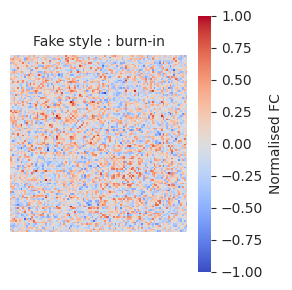

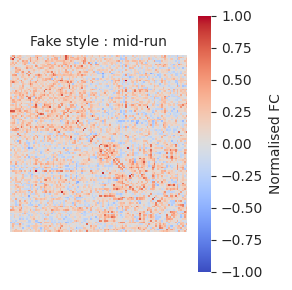

[Simulator] Simulating 8 windows 


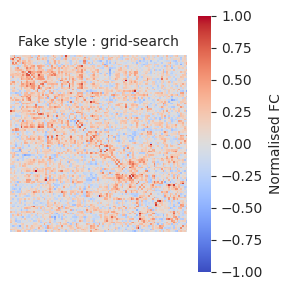

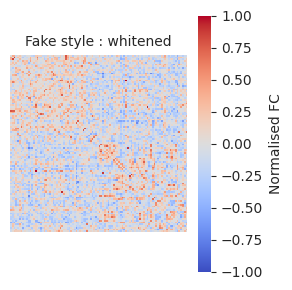

In [36]:
g_example   = 1000.0
chunk_example = 100      # good mid-range value
sim         = build_generator(sc_main, g_init=g_example, chunk=chunk_example)

# Simulate a single ∼400-TR run (plus 10 burn-in windows automatically discarded)
bold, _ = sim.simulate(u=0, num_windows=1000 // chunk_example, base_window_num=10)


# ---- a) burn-in (rank-1-ish) : use the *very first* window ------------------
bold_burn  = bold[:, :chunk_example]                              # 1 chunk
fc_burn    = fc(bold_burn)
show_and_save(fc_burn, "Fake style : burn-in", "fake_burnin_fc.png", save=False)


# ---- b) mid-run (raw) : centre of the run -----------------------------------
mid_off    = (bold.shape[1] - STACK_LEN) // 2
bold_mid   = bold[:, mid_off : mid_off + STACK_LEN]
fc_mid     = fc(bold_mid)
show_and_save(fc_mid, "Fake style : mid-run", "fake_midrun_fc.png", save=False)


# ---- c) grid-search : change (g,chunk) pair ---------------------------------
sim_grid   = build_generator(sc_main, g_init=1400.0, chunk=50)
bold_grid, _ = sim_grid.simulate(u=0, num_windows=STACK_LEN // 50, base_window_num=10)
fc_grid    = fc(bold_grid[:, :STACK_LEN])
show_and_save(fc_grid, "Fake style : grid-search", "fake_grid_fc.png", save=False)


# ---- d) whitened : z-score the mid-run FC -----------------------------------
fc_whiten  = (fc_mid - fc_mid.mean()) / fc_mid.std()
show_and_save(fc_whiten, "Fake style : whitened", "fake_whitened_fc.png", save=False)


In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

FAKE_TARGET     = 500          # total fake FCs to collect
WINDOW_STRIDE   = 50            # step (TR) when slicing one 400-TR run
MAX_SIMS        = 200           # upper-bound simulator calls

unique_fc = set()
fake_list = []


PLOT_EVERY = 300
_plot_counter = 0

def plot_fc(fc, label):
    plt.figure(figsize=(3.5, 3))
    sns.heatmap(fc, vmin=-1, vmax=1, cmap="coolwarm", cbar=False, square=True)
    plt.title(f"Fake style : {label}")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

def fc_corr(a, b):
    tri = np.tril_indices_from(a, -1)
    return np.corrcoef(a[tri], b[tri])[0, 1]

def add_fc(arr, label=""):
    global _plot_counter
    key = arr.astype(np.float16).tobytes()
    if key not in unique_fc:
        unique_fc.add(key)
        fake_list.append(arr)
        if len(fake_list) % PLOT_EVERY == 0:
            _plot_counter += 1
            r = fc_corr(arr, fc_emp)
            print(f"[plot {_plot_counter}] {label} r = {r:.3f}")
            plot_fc(arr, label)


progress = trange(FAKE_TARGET, desc="Building fake pool")
while len(fake_list) < FAKE_TARGET and len(unique_fc) < FAKE_TARGET and len(fake_list) < MAX_SIMS*16:
    # --- random simulator ------------------------------------------------------
    g_val   = np.random.uniform(600, 1500)
    chunk   = np.random.choice([50, 100, 200])
    sim     = build_generator(sc_main, g_init=g_val, chunk=chunk)
    bold, _ = sim.simulate(u=0, num_windows=1000//chunk, base_window_num=10)

    # --- sliding windows -------------------------------------------------------
    for off in range(0, bold.shape[1]-STACK_LEN+1, WINDOW_STRIDE):
        fc_raw  = fc(bold[:, off:off+STACK_LEN])          # EASY
        fc_z    = (fc_raw - fc_raw.mean())/fc_raw.std()         # HARD (whiten)
        add_fc(fc_raw, f"g={g_val}, chunk={chunk}")
        add_fc(fc_z, f"g={g_val}, chunk={chunk}")
        if len(fake_list) >= FAKE_TARGET: break
    progress.update(len(fake_list)-progress.n)
    print(len(fake_list)-progress.n)

# while len(fake_list) < FAKE_TARGET:
#     x = np.random.randn(N, STACK_LEN)
#     add_fc(fc(x))

print(f"Collected {len(fake_list)} unique fake FCs")


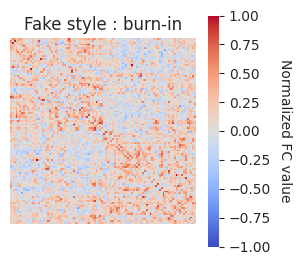

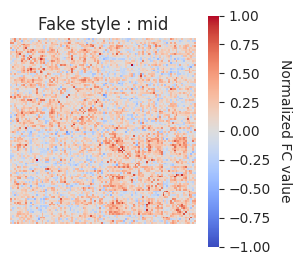

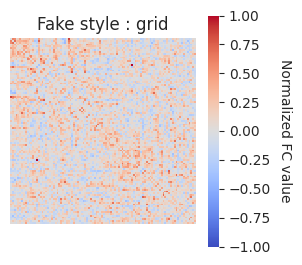

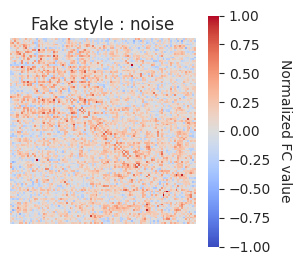

In [21]:

for title,mat in zip(["burn-in","mid","grid","noise"],
                     [fake_list[0], fake_list[FAKE_PER_STYLE],
                      fake_list[2*FAKE_PER_STYLE], fake_list[-FAKE_PER_STYLE]]):
    viz_matrix(mat, f"Fake style : {title}")

In [7]:
def save_lists(real_list, fake_list, save_dir="fc_lists"):
    os.makedirs(save_dir, exist_ok=True)
    np.save(os.path.join(save_dir, "real_list.npy"), np.array(real_list, dtype=np.float32))
    np.save(os.path.join(save_dir, "fake_list.npy"), np.array(fake_list, dtype=np.float32))
    print(f"Saved real_list and fake_list to {save_dir}")

def load_lists(save_dir="fc_lists"):
    real_path = os.path.join(save_dir, "real_list.npy")
    fake_path = os.path.join(save_dir, "fake_list.npy")
    real_list = np.load(real_path)
    fake_list = np.load(fake_path)
    print(f"Loaded real_list and fake_list from {save_dir}")
    return real_list, fake_list

real_list, fake_list = load_lists()

# save_lists(np.array(real_list, dtype=np.float32), np.array(fake_list, dtype=np.float32))
print(f"Real length = {len(real_list)}, {real_list.dtype}")
print(f"Fake length = {len(fake_list)}, {fake_list.dtype}")

Loaded real_list and fake_list from fc_lists
Real length = 320, float32
Fake length = 500, float32


In [8]:
class FCDataset(Dataset):
    def __init__(self, matrices, label, train_time_aug=False, noise_std=0.03):
        self.X = torch.tensor(matrices, dtype=torch.float32).unsqueeze(1)  # on CPU initially
        self.y = torch.full((len(matrices), 1), float(label), dtype=torch.float32)

        self.train_time_aug = train_time_aug
        self.noise_std = noise_std

    def __len__(self): return len(self.X)

    def __getitem__(self, i):
        x = self.X[i]
        if self.train_time_aug:
            noise = torch.randn_like(x) * self.noise_std
            x = (x + noise).clamp(-1, 1)
        return x, self.y[i]

In [12]:
from sklearn.model_selection import train_test_split

print(f"Fake: {len(fake_list)}, Real: {len(real_list)}")

X_fake_train, X_fake_test = train_test_split(fake_list, test_size=0.2, random_state=42)
X_real_train, X_real_test = train_test_split(real_list, test_size=0.2, random_state=42)

train_ds = torch.utils.data.ConcatDataset([
    FCDataset(X_real_train, 1, train_time_aug=True),
    FCDataset(X_fake_train, 0, train_time_aug=True)
])
test_ds = torch.utils.data.ConcatDataset([
    FCDataset(X_real_test, 1, train_time_aug=False),
    FCDataset(X_fake_test, 0, train_time_aug=False)
])
train_loader = DataLoader(train_ds, batch_size=BATCH_DISC, shuffle=True, drop_last=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_DISC, shuffle=False, drop_last=False)


# real_ds = FCDataset(real_list, 1, train_time_aug=True)
# fake_ds = FCDataset(fake_list, 0, train_time_aug=True)

# train_ds = torch.utils.data.ConcatDataset([real_ds, fake_ds])
# train_loader = DataLoader(train_ds, batch_size=BATCH_DISC,
#                           shuffle=True, drop_last=True)

print(f"TRAIN SIZE: {len(train_ds)}, TEST SIZE {len(test_ds)}")
print(f"TRAIN SIZE: {len(train_loader)}, TEST SIZE {len(test_loader)}")


Fake: 500, Real: 320
TRAIN SIZE: 656, TEST SIZE 164
TRAIN SIZE: 20, TEST SIZE 6


In [9]:
import torch.nn as nn

class LightFCCNN(nn.Module):
    """ lower-capacity head + hinge output (no sigmoid) """
    def __init__(self,n_nodes):
        super().__init__()
        self.feat = nn.Sequential(
            nn.Conv2d(1,16,5,padding=2), nn.InstanceNorm2d(16), nn.LeakyReLU(0.2),
            nn.AvgPool2d(2),
            nn.Conv2d(16,32,5,padding=2), nn.InstanceNorm2d(32), nn.LeakyReLU(0.2),
        )
        self.clf  = nn.Sequential(
            nn.AdaptiveAvgPool2d(1), nn.Flatten(),
            nn.Linear(32,32), nn.LeakyReLU(0.2), nn.Dropout(0.3),
            nn.Linear(32,1)              # raw score
        )
        self.apply(self._init)
    @staticmethod
    def _init(m):
        if isinstance(m,nn.Conv2d): nn.init.kaiming_normal_(m.weight)

    def forward(self,x):               # x : (B,1,N,N)
        return self.clf(self.feat(x))  # (B,1) (no sigmoid)

# disc = LightFCCNN(N).to(DEVICE)

In [17]:
def d_loss_fn(real_scores, fake_scores):
    return (torch.relu(1. - real_scores).mean() +
            torch.relu(1. + fake_scores).mean())

def g_loss_fn(fake_scores):
    return -fake_scores.mean()

disc = LightFCCNN(N).to(DEVICE)
# disc.load_state_dict(torch.load(SAVE_PATH))
optD = torch.optim.Adam(disc.parameters(), 3e-4, betas=(0.5,0.9))

In [18]:
history = {"D_real":[], "D_fake":[]}

disc.train()
EPOCHS_DISC = 50
for ep in range(EPOCHS_DISC):
    pbar = trange(len(train_loader), desc=f"epoch {ep+1}/{EPOCHS_DISC}", leave=False)
    total_loss = 0.0
    for X,y in train_loader:
        X = X.to(DEVICE)
        y = y.to(DEVICE)
        optD.zero_grad()
        scores = disc(X)
        real_scores = scores[y>0.5]
        fake_scores = scores[y<0.5]
        loss = d_loss_fn(real_scores, fake_scores)
        loss.backward()
        optD.step()
        history["D_real"].append(real_scores.mean().item())
        history["D_fake"].append(fake_scores.mean().item())
        total_loss += loss.item()
    print(ep, total_loss / len(train_loader))
    pbar.set_postfix(loss=f"{total_loss / len(train_loader):.3f}")


epoch 1/50:   0%|          | 0/20 [00:00<?, ?it/s, loss=2.001]

0 2.0007637619972227


1 1.988175815343857


epoch 3/50:   0%|          | 0/20 [00:00<?, ?it/s, loss=1.988]

2 1.9880176663398743


3 1.979594987630844


epoch 5/50:   0%|          | 0/20 [00:00<?, ?it/s, loss=1.970]

4 1.96957488656044


5 1.959706473350525


epoch 7/50:   0%|          | 0/20 [00:00<?, ?it/s, loss=1.953]

6 1.9531812787055969


7 1.9400957643985748


epoch 9/50:   0%|          | 0/20 [00:00<?, ?it/s, loss=1.916]

8 1.9155829966068267


9 1.9143325507640838


epoch 11/50:   0%|          | 0/20 [00:00<?, ?it/s, loss=1.895]

10 1.8946968197822571


11 1.8721877872943877


epoch 13/50:   0%|          | 0/20 [00:00<?, ?it/s, loss=1.849]

12 1.8494396805763245


13 1.839083194732666


epoch 15/50:   0%|          | 0/20 [00:00<?, ?it/s, loss=1.812]

14 1.8117681682109832


15 1.7710754334926606


epoch 17/50:   0%|          | 0/20 [00:00<?, ?it/s, loss=1.740]

16 1.7395076215267182


17 1.7144411206245422


epoch 19/50:   0%|          | 0/20 [00:00<?, ?it/s, loss=1.681]

18 1.6805545747280122


19 1.654025560617447


epoch 21/50:   0%|          | 0/20 [00:00<?, ?it/s, loss=1.638]

20 1.6384699404239655


21 1.5958366572856904


epoch 23/50:   0%|          | 0/20 [00:00<?, ?it/s, loss=1.552]

22 1.5521326124668122


23 1.5029701828956603


epoch 25/50:   0%|          | 0/20 [00:00<?, ?it/s, loss=1.445]

24 1.4452752411365508


25 1.4287043750286101


epoch 27/50:   0%|          | 0/20 [00:00<?, ?it/s, loss=1.389]

26 1.3894628882408142


27 1.3180552124977112


epoch 29/50:   0%|          | 0/20 [00:00<?, ?it/s, loss=1.288]

28 1.2884647488594054


29 1.2251283884048463


epoch 31/50:   0%|          | 0/20 [00:00<?, ?it/s, loss=1.154]

30 1.154450884461403


31 1.0678094983100892


epoch 33/50:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.971]

32 0.9710637181997299


33 0.9227501094341278


epoch 35/50:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.884]

34 0.8838900208473206


35 0.8312437385320663


epoch 37/50:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.776]

36 0.7764136716723442


37 0.7384873703122139


epoch 39/50:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.713]

38 0.7125400647521019


39 0.6918320178985595


epoch 41/50:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.650]

40 0.6502963200211525


41 0.6391454190015793


epoch 43/50:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.597]

42 0.5968989223241806


43 0.5804152697324753


epoch 45/50:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.557]

44 0.5567771971225739


45 0.5146745920181275


epoch 47/50:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.477]

46 0.4770266696810722


47 0.47855509966611864


epoch 49/50:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.424]

48 0.4238112524151802


49 0.395489464700222


In [19]:
def eval_disc(loader, disc):
    disc.eval()
    scores, labels = [], []
    print(f"Loader length = {len(loader)}")
    with torch.no_grad():
        for x, y in loader:
            x = x.to(DEVICE)
            y = y.to(DEVICE)
            p = disc(x)
            scores.extend(p.cpu().numpy().flatten())
            labels.extend(y.cpu().numpy().flatten())
    return np.mean(scores[:len(labels)//2]), np.mean(scores[len(labels)//2:])

r_mean, f_mean = eval_disc(test_loader, disc)
print(f"VALIDATION: mean p(real)={r_mean:.3f}, p(fake)={f_mean:.3f}")


Loader length = 6
VALIDATION: mean p(real)=0.412, p(fake)=-1.543


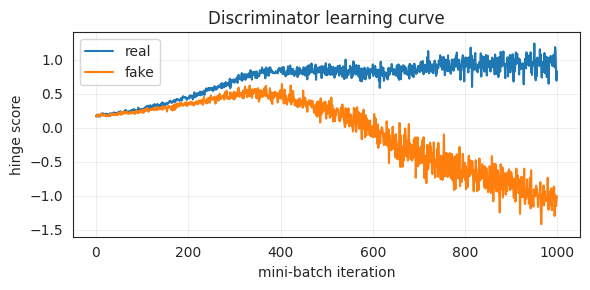

Loader length = 6


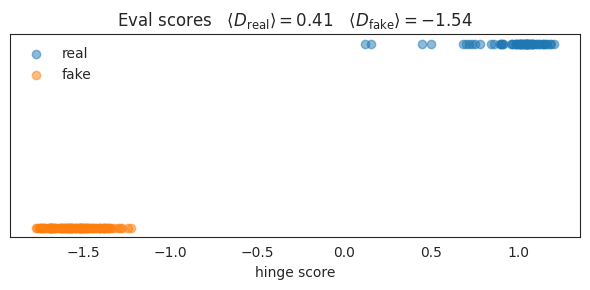

In [20]:
# --- 1) training-curve figure -------------------------------------------------
plt.figure(figsize=(6,3))
plt.plot(history["D_real"], label="real")
plt.plot(history["D_fake"], label="fake")
plt.xlabel("mini-batch iteration")
plt.ylabel("hinge score")
plt.ylim(-1.6, 1.4)
plt.legend(); plt.grid(alpha=.3)
plt.title("Discriminator learning curve")
plt.tight_layout()
#plt.savefig("figures/D_training_curve.pdf", dpi=300)
plt.show()

# --- 2) held-out scatter ------------------------------------------------------
r_mean, f_mean = eval_disc(test_loader, disc)        # code supplied earlier
real_scores = []; fake_scores = []
with torch.no_grad():
    for X,y in test_loader:
        s = disc(X.to(DEVICE)).cpu().numpy().flatten()
        real_scores.extend(s[y.numpy().flatten()>0.5])
        fake_scores.extend(s[y.numpy().flatten()<0.5])
plt.figure(figsize=(6,3))
plt.scatter(real_scores, [1]*len(real_scores), alpha=.5, label="real", c="tab:blue")
plt.scatter(fake_scores, [0]*len(fake_scores), alpha=.5, label="fake", c="tab:orange")
plt.yticks([]); plt.xlabel("hinge score"); plt.legend(frameon=False)
plt.title(f"Eval scores   $\\langle D_{{\\text{{real}}}}\\rangle={r_mean:.2f}$   "
          f"$\\langle D_{{\\text{{fake}}}}\\rangle={f_mean:.2f}$")
plt.tight_layout()
# plt.savefig("figures/D_eval_scatter.pdf", dpi=300)
plt.show()


In [21]:

num_params = sum(p.numel() for p in disc.parameters())
print(f"Discriminator has {num_params} parameters")
print("Parameter shapes and locations:")
for name, param in disc.named_parameters():
    print(f"  {name}: {tuple(param.shape)}")



Discriminator has 14337 parameters
Parameter shapes and locations:
  feat.0.weight: (16, 1, 5, 5)
  feat.0.bias: (16,)
  feat.4.weight: (32, 16, 5, 5)
  feat.4.bias: (32,)
  clf.2.weight: (32, 32)
  clf.2.bias: (32,)
  clf.5.weight: (1, 32)
  clf.5.bias: (1,)


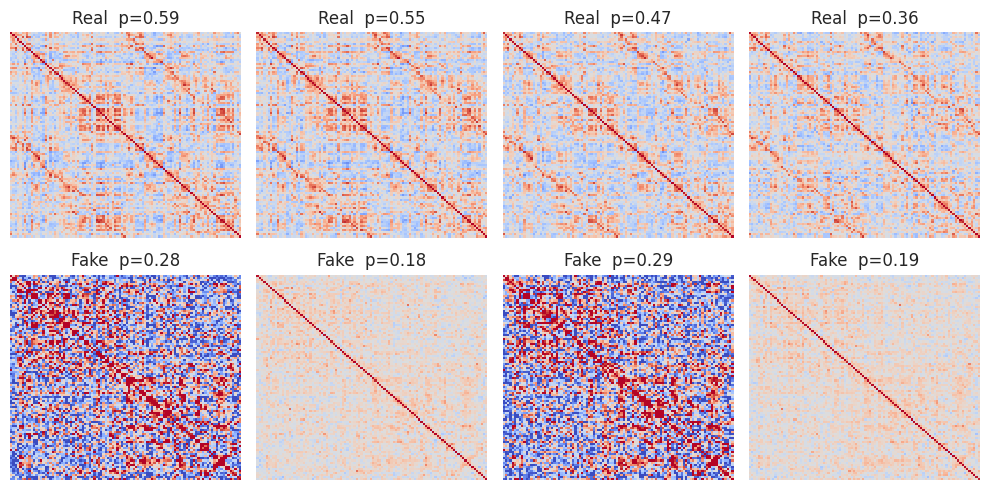

In [67]:
def viz_disc_outputs(num=4):
    disc.eval()
    real_batch = torch.stack([real_ds[-i-10][0] for i in range(num)]).to(DEVICE)
    fake_batch = torch.stack([fake_ds[-i-15][0] for i in range(num)]).to(DEVICE)

    with torch.no_grad():
        pr = disc(real_batch).sigmoid().cpu().numpy().flatten()
        pf = disc(fake_batch).sigmoid().cpu().numpy().flatten()

    fig,ax = plt.subplots(2,num,figsize=(2.5*num,5))
    v=dict(vmin=-1,vmax=1,cmap='coolwarm')
    for i in range(num):
        sns.heatmap(real_batch[i,0].cpu(),ax=ax[0,i],cbar=False,**v)
        ax[0,i].set_title(f"Real  p={pr[i]:.2f}"); ax[0,i].axis('off')
        sns.heatmap(fake_batch[i,0].cpu(),ax=ax[1,i],cbar=False,**v)
        ax[1,i].set_title(f"Fake  p={pf[i]:.2f}"); ax[1,i].axis('off')
    plt.tight_layout(); plt.show()

viz_disc_outputs()


In [22]:
print("training finished - saving to", SAVE_PATH)
torch.save(disc.state_dict(), SAVE_PATH)

training finished - saving to weights/disc_sub018_len400_hinge.pt


### Old Training

In [5]:
def emp_fc_windows(subj):
    ts = loader.all_bold[subj]                         # (N,T)
    N, T = ts.shape
    usable = (T // STACK_LEN) * STACK_LEN
    return [fc(ts[:, i:i+STACK_LEN]) for i in range(0, usable, CHUNK)]

emp_FCs = emp_fc_windows(SUBJ_MAIN)
AUGMENT_SUBJECTS   = [1, 2, 3]
for s in AUGMENT_SUBJECTS:
    emp_FCs += emp_fc_windows(s)
print(f"Collected {len(emp_FCs)} empirical FC-{STACK_LEN} matrices")


Collected 32 empirical FC-400 matrices


In [14]:
# Compute pairwise fc_corr for all pairs in emp_FCs
n = len(emp_FCs)
corr_matrix = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        corr_matrix[i, j] = fc_corr(emp_FCs[i], emp_FCs[j])

# Compute mean and std of the off-diagonal fc_corrs
tri = np.tril_indices(n, k=-1)
pairwise_corrs = corr_matrix[tri]
print(f"Mean pairwise fc_corr: {pairwise_corrs.mean():.3f} ± {pairwise_corrs.std():.3f}")



Mean pairwise fc_corr: 0.456 ± 0.096


In [6]:
def sim_fc_batch(sim, batch_size):
    with torch.no_grad():
        out = []
        while len(out) < batch_size:
            ts, _ = sim.simulate(u=0, num_windows=K_STACK, base_window_num=10)
            print(ts.shape)
            out.append(fc(ts))
        return out[:batch_size]

# quick sample to make sure variability is OK
sample_fake = sim_fc_batch(sim, 3)
print("Example fake-vs-fake r:",
      fc_corr(sample_fake[0], sample_fake[1]))

[Simulator] Simulating 4 windows 
(100, 400)
[Simulator] Simulating 4 windows 
(100, 400)
[Simulator] Simulating 4 windows 
(100, 400)
Example fake-vs-fake r: 0.5459912217079737


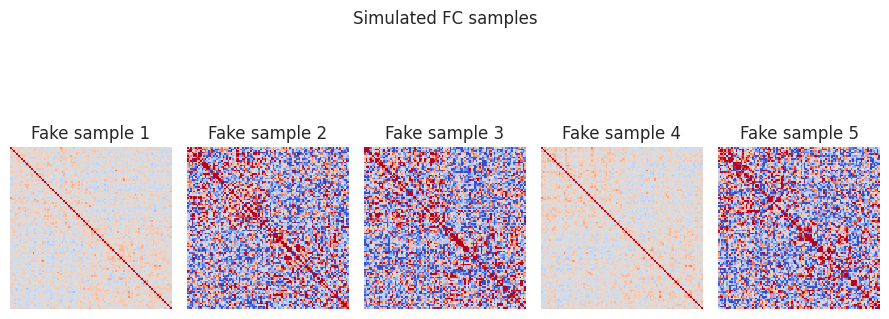

In [74]:
plt.figure(figsize=(9, 4))
for i, fc_mat in enumerate(random.sample(fake_list, 5)):
    plt.subplot(1, 5, i+1)
    sns.heatmap(fc_mat, vmin=-1, vmax=1, cmap="coolwarm", cbar=False, square=True)
    plt.title(f"Fake sample {i+1}")
    plt.axis('off')
plt.suptitle("Simulated FC samples")
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [8]:
class FCDataset(Dataset):
    def __init__(self, fc_list, label):
        self.x  = torch.tensor(fc_list, dtype=torch.float32)
        self.x  = self.x.unsqueeze(1)          # (B, 1, N, N)
        self.y  = torch.full((len(fc_list),1), float(label))
    def __len__(self): return len(self.x)
    def __getitem__(self, i): return self.x[i], self.y[i]

real_ds = FCDataset(emp_FCs, 1)
# build fake set to roughly match size of real
fake_ds = FCDataset([fc for _ in range((len(real_ds)//BATCH_SIM)+1)
                           for fc in sim_fc_batch(sim, BATCH_SIM)],
                    0)
print(f"fake set size   : {len(fake_ds)}")
print(f"real set size   : {len(real_ds)}")

train_loader = DataLoader(torch.utils.data.ConcatDataset([real_ds, fake_ds]),
                          batch_size=BATCH_DISC, shuffle=True, drop_last=True)



/tmp/ipykernel_3160767/4113936024.py:3: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  self.x  = torch.tensor(fc_list, dtype=torch.float32)


[Simulator] Simulating 4 windows 
(100, 400)
[Simulator] Simulating 4 windows 
(100, 400)
[Simulator] Simulating 4 windows 
(100, 400)
[Simulator] Simulating 4 windows 
(100, 400)
[Simulator] Simulating 4 windows 
(100, 400)
[Simulator] Simulating 4 windows 
(100, 400)
[Simulator] Simulating 4 windows 
(100, 400)
[Simulator] Simulating 4 windows 
(100, 400)
[Simulator] Simulating 4 windows 
(100, 400)
[Simulator] Simulating 4 windows 
(100, 400)
[Simulator] Simulating 4 windows 
(100, 400)
[Simulator] Simulating 4 windows 
(100, 400)
[Simulator] Simulating 4 windows 
(100, 400)
[Simulator] Simulating 4 windows 
(100, 400)
[Simulator] Simulating 4 windows 
(100, 400)
[Simulator] Simulating 4 windows 
(100, 400)
[Simulator] Simulating 4 windows 
(100, 400)
[Simulator] Simulating 4 windows 
(100, 400)
[Simulator] Simulating 4 windows 
(100, 400)
[Simulator] Simulating 4 windows 
(100, 400)
[Simulator] Simulating 4 windows 
(100, 400)
[Simulator] Simulating 4 windows 
(100, 400)
[Simulator

In [9]:
disc = FCCNNDisc(sim.model.node_size).to(DEVICE)
opt  = torch.optim.Adam(disc.parameters(), lr=1e-4, betas=(0.5,0.999))
bce  = torch.nn.BCELoss()
EPOCHS_DISC = 30
print(len(train_loader))
for ep in range(EPOCHS_DISC):
    disc.train()
    pbar = trange(len(train_loader), desc=f"epoch {ep+1}/{EPOCHS_DISC}", leave=False)
    for xb,yb in train_loader:
        xb,yb = xb.to(DEVICE), yb.to(DEVICE)
        opt.zero_grad()
        loss = bce(disc(xb), yb)
        loss.backward(); opt.step()
        # print(f"E{ep} loss={loss.item():.4f}")
        pbar.set_postfix(loss=f"{loss.item():.3f}")


2


[Simulator] Simulating 4 windows 
(100, 400)
[Simulator] Simulating 4 windows 
(100, 400)
[Simulator] Simulating 4 windows 


(100, 400)
[Simulator] Simulating 4 windows 
(100, 400)


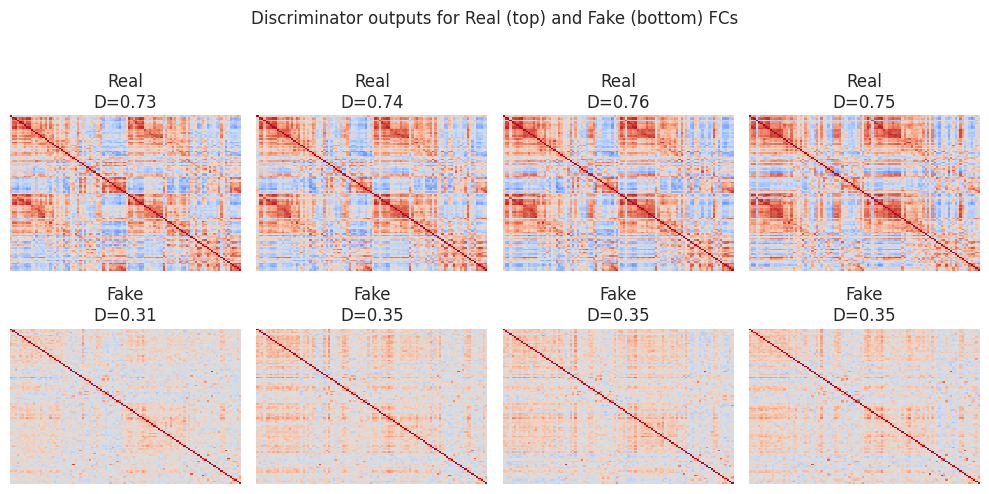

In [10]:
disc.eval()
# test_fake = torch.tensor(sim_fc_batch(sim, 32), dtype=torch.float32).unsqueeze(1).to(DEVICE)
# print("mean p(fake)  on new sims :", disc(test_fake).mean().item())
# test_real = real_ds.x[:32].to(DEVICE)
# print("mean p(real)  on held emp :", disc(test_real).mean().item())

def viz_disc_outputs(num_examples=4):
    disc.eval()
    # Get real and fake examples
    real_examples = real_ds.x[:num_examples].to(DEVICE)
    fake_examples = torch.tensor(sim_fc_batch(sim, num_examples), dtype=torch.float32).unsqueeze(1).to(DEVICE)
    # Get discriminator outputs
    with torch.no_grad():
        real_scores = disc(real_examples).cpu().numpy().flatten()
        fake_scores = disc(fake_examples).cpu().numpy().flatten()
    # Plot
    fig, ax = plt.subplots(2, num_examples, figsize=(2.5*num_examples, 5))
    v = dict(vmin=-1, vmax=1, cmap="coolwarm")
    for i in range(num_examples):
        # Real
        mat_real = real_examples[i,0].cpu().numpy()
        sns.heatmap(mat_real, ax=ax[0,i], **v, cbar=False)
        ax[0,i].set_title(f"Real\nD={real_scores[i]:.2f}")
        ax[0,i].axis('off')
        # Fake
        mat_fake = fake_examples[i,0].cpu().numpy()
        sns.heatmap(mat_fake, ax=ax[1,i], **v, cbar=False)
        ax[1,i].set_title(f"Fake\nD={fake_scores[i]:.2f}")
        ax[1,i].axis('off')
    plt.suptitle("Discriminator outputs for Real (top) and Fake (bottom) FCs")
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

viz_disc_outputs()



In [11]:
Path(DISC_WEIGHTS_OUT).parent.mkdir(parents=True, exist_ok=True)
torch.save(disc.state_dict(), DISC_WEIGHTS_OUT)
print(f"Discriminator saved  →  {DISC_WEIGHTS_OUT}")


Discriminator saved  →  weights/disc_sub018_len400.pt


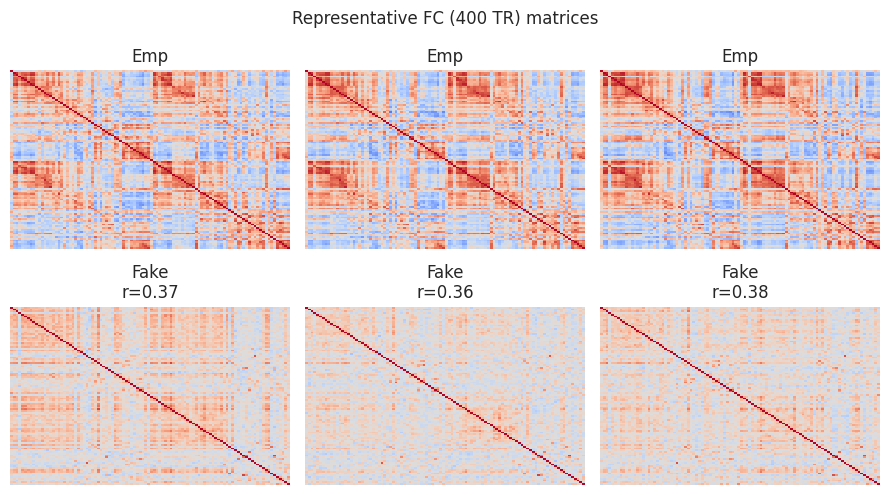

In [25]:
def viz_examples():
    fig,ax = plt.subplots(2,3, figsize=(9,5))
    v = dict(vmin=-1,vmax=1,cmap="coolwarm")
    for i in range(3):
        emp = real_ds.x[i,0].numpy(); fak = fake_ds.x[i,0].numpy()
        r_e = fc_corr(emp, fak)
        sns.heatmap(emp, ax=ax[0,i], **v, cbar=False); ax[0,i].set_title("Emp")
        sns.heatmap(fak, ax=ax[1,i], **v, cbar=False); ax[1,i].set_title(f"Fake\nr={r_e:.2f}")
        [a.axis('off') for a in ax[:,i]]
    plt.suptitle("Representative FC (400 TR) matrices"); plt.tight_layout(); plt.show()
viz_examples()
